## Create microscopy labels for dataset

In [11]:
import pandas as pd
import csv
import os

## 1. Create labels file
Create a csv file with an id, figure name, modality (e.g. DMEL), set (train/validation) and image path to feed a Dataset class.

In [10]:
BASE_URL = '/mnt'
OUTPUT_PATH = '../labels/microscopy.csv'

In [22]:
with open(OUTPUT_PATH, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'NAME', 'MODALITY', 'SET', 'PATH'])
    i = 1
    
    for images_group in ('train', 'validation'):
        images_group_dir = '{0}/{1}'.format(BASE_URL, images_group)
        for microscopy_label in os.listdir(images_group_dir):
            microscopy_class_dir = '{0}/{1}'.format(images_group_dir, microscopy_label)
            for image_name in os.listdir(microscopy_class_dir):
                img_path = '{0}/{1}'.format(microscopy_class_dir, image_name)
                row = [i, image_name, microscopy_label, images_group, img_path]
                writer.writerow(row)
                i += 1

In [23]:
df = pd.read_csv(OUTPUT_PATH)
df.head()

,ID,NAME,MODALITY,SET,PATH
0,1,1423-0127-16-7-1-2.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-2.jpg
1,2,1423-0127-16-7-1-4.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-4.jpg
2,3,1423-0127-16-7-1-5.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-5.jpg
3,4,1423-0127-16-7-1-6.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-6.jpg
4,5,1423-0127-16-88-1-1.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-88-1-1.jpg


<AxesSubplot:xlabel='MODALITY'>

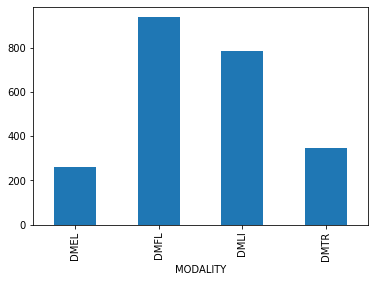

In [26]:
df.groupby(['MODALITY'])['ID'].count().plot.bar()

## 2. Get normalization values

In [28]:
df[df['SET'] == 'train']

,ID,NAME,MODALITY,SET,PATH
0,1,1423-0127-16-7-1-2.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-2.jpg
1,2,1423-0127-16-7-1-4.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-4.jpg
2,3,1423-0127-16-7-1-5.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-5.jpg
3,4,1423-0127-16-7-1-6.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-6.jpg
4,5,1423-0127-16-88-1-1.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-88-1-1.jpg
...,...,...,...,...,...
1857,1858,gb-2007-8-7-r144-4-10.jpg,DMTR,train,/mnt/train/DMTR/gb-2007-8-7-r144-4-10.jpg
1858,1859,gb-2007-8-7-r144-4-7.jpg,DMTR,train,/mnt/train/DMTR/gb-2007-8-7-r144-4-7.jpg
1859,1860,IJBI2010-674582.003-1.jpg,DMTR,train,/mnt/train/DMTR/IJBI2010-674582.003-1.jpg
1860,1861,IJBI2010-674582.003-2.jpg,DMTR,train,/mnt/train/DMTR/IJBI2010-674582.003-2.jpg


In [30]:
df['MODALITY'].unique().tolist()

['DMEL', 'DMFL', 'DMLI', 'DMTR']

In [32]:
df.iloc[5, 4]

'/mnt/train/DMEL/1423-0127-17-77-3-1.jpg'

In [39]:
df.index[df['ID']==4][0]

3